<a href="https://colab.research.google.com/github/thravt/AIProjectsHomework/blob/main/HW5_Task3_Tyler_Thraves.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Part 1 (10 points): Implement the scaled dot-product attention as discussed in class
(lecture 14) from scratch (use NumPy and pandas only, no deep learning libraries are
allowed for this step).**

To do this, I will create mini-functions step of the process, then string them all together for an overall function. For this function I'm expecting the query, key and value to be numpy vectors, but if they're a pandas database I can easily just take the columns and use .values and reshape if needed to get the 2d shape.

In [ ]:
import numpy as np
import pandas as pd

Step one is to get the dot product of the query and the key.

In [2]:
def QueryKeydot(query, key):
  return np.dot(query, key.T)

Step 2 is to divide the dot product by the square root of the dimensionality of the key to scale it.

In [3]:
def Scale(dotprod, key):
  scaleval = np.sqrt(len(key))
  return dotprod / scaleval

Step 3 is to normalize the data by taking the softmax of that new value.

In [4]:
def Softmax(scaledprod):
  expvals = np.exp(scaledprod)

  return expvals / np.sum(expvals)

Step 4 is to multiply the new softmax matrix with the vector of values.

In [5]:
def ValueMult(softvals, value):
  return np.dot(softvals, value)

Now to put it all together into a single function:

In [6]:
def ScaledDPA(query, key, value):
  dotprod = QueryKeydot(query, key)
  scaledprod = Scale(dotprod, key)
  softvals = Softmax(scaledprod)
  return ValueMult(softvals, value)

A small test:

In [7]:
Q = np.array([[1, 2, 3], [2, 4, 6], [3, 6, 9]])
K = np.array([[1, 2, 3], [2, 4, 6], [3, 6, 9], [4, 8, 12]])
V = np.array([[1], [2], [3], [4]])

In [8]:
QK = QueryKeydot(Q, K)
print(QK)

[[ 14  28  42  56]
 [ 28  56  84 112]
 [ 42  84 126 168]]


In [10]:
Sc = Scale(QK, K)
print(Sc)
print(Sc * np.sqrt(3))

[[ 7. 14. 21. 28.]
 [14. 28. 42. 56.]
 [21. 42. 63. 84.]]
[[ 12.12435565  24.24871131  36.37306696  48.49742261]
 [ 24.24871131  48.49742261  72.74613392  96.99484522]
 [ 36.37306696  72.74613392 109.11920088 145.49226784]]


In [11]:
Soft = Softmax(Sc)
print(Soft)
print(np.sum(Soft))

[[3.62514092e-34 3.97544973e-31 4.35961000e-28 4.78089288e-25]
 [3.97544973e-31 4.78089288e-25 5.74952226e-19 6.91440010e-13]
 [4.35961000e-28 5.74952226e-19 7.58256042e-10 9.99999999e-01]]
1.0


In [12]:
SDPA = ValueMult(Soft, V)
print(SDPA)

[[1.91366583e-24]
 [2.76576177e-12]
 [4.00000000e+00]]


In [13]:
print(ScaledDPA(Q, K, V))

[[1.91366583e-24]
 [2.76576177e-12]
 [4.00000000e+00]]


Good news: the functions seem to be working as intended.

**Part 2 (10 points): Pick any encoder-decoder seq2seq model (as discussed in class) and
integrate the scaled dot-product attention in the encoder architecture. You may come
up with your own technique of integration or adopt one from literature. Hint: See
Bahdanau or Luong attention paper presented in class (lecture 14).**

After searching around for a model I could implement in tensorflow, I was unable to find one. Fortunately, the teacher directed me to one I could do in pytorch. I haven't worked with pytorch before, but I should be able to handle this.

What I did was take each part of the attention function here and swap out the parts to my own attention function, that way the preprocessing this model does still works.

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(
<ipython-input-7-b42991ff2b4f>:20: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)


Epoch: 0400 cost = 0.000574
Epoch: 0800 cost = 0.000190
Epoch: 1200 cost = 0.000095
Epoch: 1600 cost = 0.000057
Epoch: 2000 cost = 0.000038
ich mochte ein bier P -> ['i', 'want', 'a', 'beer', 'E']


<ipython-input-7-b42991ff2b4f>:124: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
<ipython-input-7-b42991ff2b4f>:125: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})


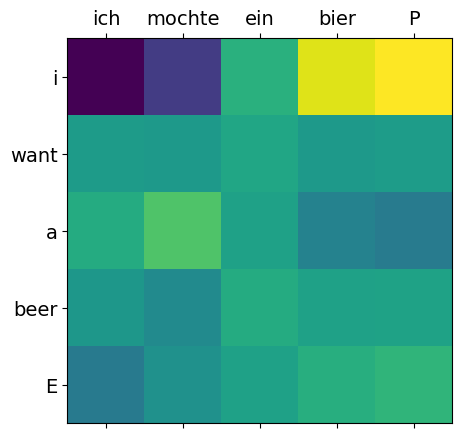

In [ ]:
# %%
# code by Tae Hwan Jung @graykode
# Reference : https://github.com/hunkim/PyTorchZeroToAll/blob/master/14_2_seq2seq_att.py
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# S: Symbol that shows starting of decoding input
# E: Symbol that shows starting of decoding output
# P: Symbol that will fill in blank sequence if current batch data size is short than time steps

def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[0].split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in sentences[1].split()]]]
    target_batch = [[word_dict[n] for n in sentences[2].split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

class Attention(nn.Module):
    def __init__(self):
        super(Attention, self).__init__()
        self.enc_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)
        self.dec_cell = nn.RNN(input_size=n_class, hidden_size=n_hidden, dropout=0.5)

        # Linear for attention
        self.attn = nn.Linear(n_hidden, n_hidden)
        self.out = nn.Linear(n_hidden * 2, n_class)

    def forward(self, enc_inputs, hidden, dec_inputs):
        enc_inputs = enc_inputs.transpose(0, 1)  # enc_inputs: [n_step(=n_step, time step), batch_size, n_class]
        dec_inputs = dec_inputs.transpose(0, 1)  # dec_inputs: [n_step(=n_step, time step), batch_size, n_class]

        # enc_outputs : [n_step, batch_size, num_directions(=1) * n_hidden], matrix F
        # enc_hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
        enc_outputs, enc_hidden = self.enc_cell(enc_inputs, hidden)

        trained_attn = []
        hidden = enc_hidden
        n_step = len(dec_inputs)
        model = torch.empty([n_step, 1, n_class])

        for i in range(n_step):  # each time step
            # dec_output : [n_step(=1), batch_size(=1), num_directions(=1) * n_hidden]
            # hidden : [num_layers(=1) * num_directions(=1), batch_size(=1), n_hidden]
            dec_output, hidden = self.dec_cell(dec_inputs[i].unsqueeze(0), hidden)
            attn_weights = self.get_att_weight(dec_output, enc_outputs)  # attn_weights : [1, 1, n_step]
            trained_attn.append(attn_weights.squeeze().data.numpy())

            # matrix-matrix product of matrices [1,1,n_step] x [1,n_step,n_hidden] = [1,1,n_hidden]
            context = torch.tensor(ValueMult(attn_weights.detach().numpy(), enc_outputs.transpose(0, 1).detach().numpy()))[0]
            #context = attn_weights.bmm(enc_outputs.transpose(0, 1))


            dec_output = dec_output.squeeze(0)  # dec_output : [batch_size(=1), num_directions(=1) * n_hidden]
            context = context.squeeze(1)  # [1, num_directions(=1) * n_hidden]
            model[i] = self.out(torch.cat((dec_output, context), 1))

        # make model shape [n_step, n_class]
        return model.transpose(0, 1).squeeze(0), trained_attn

    def get_att_weight(self, dec_output, enc_outputs):  # get attention weight one 'dec_output' with 'enc_outputs'
        n_step = len(enc_outputs)
        attn_scores = torch.zeros(n_step)  # attn_scores : [n_step]

        for i in range(n_step):
            attn_scores[i] = torch.tensor(self.get_att_score(dec_output, enc_outputs[i]))

        # Normalize scores to weights in range 0 to 1
        return torch.from_numpy(Softmax(attn_scores.detach().numpy())).view(1, 1, -1)


    def get_att_score(self, dec_output, enc_output):  # enc_outputs [batch_size, num_directions(=1) * n_hidden]
        score = self.attn(enc_output)  # score : [batch_size, n_hidden]
        return Scale(QueryKeydot(dec_output.view(-1).detach().numpy(), score.view(-1).detach().numpy()), score.view(-1).detach().numpy())


if __name__ == '__main__':
    n_step = 5 # number of cells(= number of Step)
    n_hidden = 128 # number of hidden units in one cell

    sentences = ['ich mochte ein bier P', 'S i want a beer', 'i want a beer E']

    word_list = " ".join(sentences).split()
    word_list = list(set(word_list))
    word_dict = {w: i for i, w in enumerate(word_list)}
    number_dict = {i: w for i, w in enumerate(word_list)}
    n_class = len(word_dict)  # vocab list

    # hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
    hidden = torch.zeros(1, 1, n_hidden)

    model = Attention()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    input_batch, output_batch, target_batch = make_batch()

    # Train
    for epoch in range(2000):
        optimizer.zero_grad()
        output, _ = model(input_batch, hidden, output_batch)

        loss = criterion(output, target_batch.squeeze(0))
        if (epoch + 1) % 400 == 0:
            print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

        loss.backward()
        optimizer.step()

    # Test
    test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
    test_batch = torch.FloatTensor(test_batch)
    predict, trained_attn = model(input_batch, hidden, test_batch)
    predict = predict.data.max(1, keepdim=True)[1]
    print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])

    # Show Attention
    fig = plt.figure(figsize=(5, 5))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(trained_attn, cmap='viridis')
    ax.set_xticklabels([''] + sentences[0].split(), fontdict={'fontsize': 14})
    ax.set_yticklabels([''] + sentences[2].split(), fontdict={'fontsize': 14})
    plt.show()

The colors on the distribution don't seem as varied as in the original implementation, and I've found that happens with the softmax. Turns out the issue was in the scaling for the softmax. Now it's fixed and looks pretty much the same.

**Part 3 (5 points): Pick any public dataset of your choice (use a small-scale dataset like a
subset of the Tatoeba or Multi30k dataset) for machine translation task. Train your
model from Part 2 for the machine translation task. Evaluate test set by reporting the
BLEU Score.**

I've been struggling to find a dataset to download, so for now I'll work on part 4 until it's time to download the dataset.

In [ ]:
! pip install datasets transformers torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 487.4/487.4 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
from datasets import load_dataset

# Replace 'your_dataset_name' with the actual dataset identifier from the Hugging Face Hub
dataset = load_dataset('bentrevett/multi30k', split='train')

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

train.jsonl:   0%|          | 0.00/4.60M [00:00<?, ?B/s]

val.jsonl:   0%|          | 0.00/164k [00:00<?, ?B/s]

test.jsonl:   0%|          | 0.00/156k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/29000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/1014 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
source_texts = dataset['de']
target_texts = dataset['en']

In [ ]:
print(source_texts[0])
print(target_texts[0])


Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche.
Two young, White males are outside near many bushes.


I've been running out of ram, and running the model takes forever, so I'm forced to downsize to about 100 sentences.

In [ ]:
source_texts = source_texts[0:99]
target_texts = target_texts[0:99]

In [ ]:
def make_batch():
    input_batch = [np.eye(n_class)[[word_dict[n] for n in " ".join(source_texts).split()]]]
    output_batch = [np.eye(n_class)[[word_dict[n] for n in " ".join(target_texts).split()]]]
    target_batch = [[word_dict[n] for n in " ".join(target_texts).split()]]

    # make tensor
    return torch.FloatTensor(input_batch), torch.FloatTensor(output_batch), torch.LongTensor(target_batch)

In [ ]:
n_step = 5 # number of cells(= number of Step)
n_hidden = 128 # number of hidden units in one cell

sentences = source_texts + target_texts

word_list = " ".join(sentences).split()
word_list = list(set(word_list))
word_dict = {w: i for i, w in enumerate(word_list)}
number_dict = {i: w for i, w in enumerate(word_list)}
n_class = len(word_dict)  # vocab list

In [ ]:
# hidden : [num_layers(=1) * num_directions(=1), batch_size, n_hidden]
hidden = torch.zeros(1, 1, n_hidden)

In [ ]:
" ".join(source_texts)
" ".join(target_texts)

"Two young, White males are outside near many bushes. Several men in hard hats are operating a giant pulley system. A little girl climbing into a wooden playhouse. A man in a blue shirt is standing on a ladder cleaning a window. Two men are at the stove preparing food. A man in green holds a guitar while the other man observes his shirt. A man is smiling at a stuffed lion A trendy girl talking on her cellphone while gliding slowly down the street. A woman with a large purse is walking by a gate. Boys dancing on poles in the middle of the night. A ballet class of five girls jumping in sequence. Four guys three wearing hats one not are jumping at the top of a staircase. A black dog and a spotted dog are fighting A man in a neon green and orange uniform is driving on a green tractor. Several women wait outside in a city. A lady in a black top with glasses is sprinkling powdered sugar on a bundt cake. A little girl is sitting in front of a large painted rainbow. A man lays on the bench to 

In [ ]:
model = Attention()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

input_batch, output_batch, target_batch = make_batch()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [ ]:


# Train
for epoch in range(10):
    optimizer.zero_grad()
    output, _ = model(input_batch, hidden, output_batch)

    loss = criterion(output, target_batch.squeeze(0))
    print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.6f}'.format(loss))

    loss.backward()
    optimizer.step()

# Test
test_batch = [np.eye(n_class)[[word_dict[n] for n in 'SPPPP']]]
test_batch = torch.FloatTensor(test_batch)
predict, trained_attn = model(input_batch, hidden, test_batch)
predict = predict.data.max(1, keepdim=True)[1]
print(sentences[0], '->', [number_dict[n.item()] for n in predict.squeeze()])


Epoch: 0001 cost = 6.886711
Epoch: 0002 cost = 6.848290
Epoch: 0003 cost = 6.807856
Epoch: 0004 cost = 6.761964
Epoch: 0005 cost = 6.705356
Epoch: 0006 cost = 6.629798
Epoch: 0007 cost = 6.524496
Epoch: 0008 cost = 6.383324
Epoch: 0009 cost = 6.214656
Epoch: 0010 cost = 6.035153


KeyError: 'S'

I'm running into issues with the given test batch code, so I'll use the most recent output instead.

In [ ]:
! pip install datasets

In [ ]:
! pip install datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.0 MB/s eta 0:00:00


In [ ]:
from evaluate import load
bleu = load("bleu")

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

In [ ]:
print(input_batch.shape)

torch.Size([1, 1138, 974])


In [ ]:
print(output.shape)

torch.Size([1184, 974])


In [ ]:
predict = output.data.max(1, keepdim=True)[1]

In [ ]:
print(predict.shape)

torch.Size([1184, 1])


In [ ]:
print(source_texts[0], '->', [number_dict[n.item()] for n in predict[0]])

Zwei junge weiße Männer sind im Freien in der Nähe vieler Büsche. -> ['Two']


In [ ]:
results = bleu.compute(predictions=predictions, references=target_texts)
print(results)

ValueError: Mismatch in the number of predictions (1184) and references (99)

Ok, there's also problems running BLEU, as I can't figure out how to get the sentences from the output.

**Part 4 (30 points): In this part you are required to implement a simplified Transformer
model from scratch (using Python and NumPy/PyTorch/TensorFlow with minimal highlevel abstractions) and apply it to a machine translation task (e.g., English-to-French or
English-to-German translation) using the same dataset from part 3.**

With the issues I've run into in part 3, I don't think I'm going to be able to properly test the transformer I make here. I'll hope that my understanding of a transformer model gives me partial credit, but the amount of time I'd have to spend to research and redo everything isn't worth the grade percentage I might lose out on.

There are deviations from the original paper that are specified in the HW details (such as using 2 attention heads instead of 8), but I'll mention them as I get to them.

In [1]:
import numpy as np

There are 5 key components to this: first of which is the Position encoding.

The first change is that the embedding dimension for this will be 64 instead of the usual 512, so I might as well hard code that in.

In [ ]:
def PositionalEncoding(position):
  encoding = np.zeros((1, 64))
  #Looping through all elements of the embedding
  #Since every other is cosine, will step by 2 each loop
  for i in range(0, 64, 2):
    encoding[0][i] = np.sin(position / (10000 ** ((2 * i) / 64)))
    encoding[0][i + 1] = np.cos(position / (10000 ** ((2 * i) / 64)))
  return encoding

The second component is the scaled dot product attention. Fortunately, I've already prepared this function ahead of time.

This will be useful in the third part: the multi-headed attention.

This comes with the next change: there's only 2 heads. In order to handle this, I'll have 3 variables split and multiplied by weight matrices to be trained, then multiply the final concatenated matrix by a final weight matrix to be trained. This split and matrix defining will happen in an overall class, in order to train the model properly.

In [ ]:
def TwoHeadAttention(query1, key1, value1, query2, key2, value2, overall):
  head1 = ScaledDPA(query1, key1, value1)
  head2 = ScaledDPA(query2, key2, value2)
  concatenated = np.concatenate((head1, head2), axis = 0)
  return np.dot(concatenated, overall)


Component number 4 is the encoder and decoder blocks.


This comes with 2 more changes:

The amount of encoder and decoder blocks is now only 2.

The feed forward dimension is now 128.


I will be starting with the encoder.

In order to store the matrices, I will make this encoder a class.

In [ ]:
class Encoder():
  def __init__(self):
    self.attention = TwoHeadAttention
    self.W1 = np.random.randn(128, 1) / 1000
    self.W2 = np.random.randn(128, 1) / 1000
    self.b1 = np.random.randn(1) / 1000
    self.b2 = np.random.randn(1) / 1000
    self.query1 = np.random.randn(64, 64) / 1000
    self.query2 = np.random.randn(64, 64) / 1000
    self.key1 = np.random.randn(64, 64) / 1000
    self.key2 = np.random.randn(64, 64) / 1000
    self.value1 = np.random.randn(64, 64) / 1000
    self.value2 = np.random.randn(64, 64) / 1000
    self.finalweight = np.random.randn(128, 128)

  def runthrough(self, input):
    input1, input2 = np.split(input, 2)
    query1 = np.dot(input1, self.query1)
    key1 = np.dot(input1, self.key1)
    value1 = np.dot(input1, self.value1)
    query2 = np.dot(input2, self.query2)
    key2 = np.dot(input2, self.key2)
    value2 = np.dot(input2, self.value2)
    attentionvalue = self.attention(query1, key1, value1, query2, key2, value2, self.finalweight)
    attentionvalue = attentionvalue + input
    #Feed forward
    reluvalue = max(0, np.dot(attentionvalue, self.W1) + self.b1)
    reluvalue = reluvalue * self.W2
    return reluvalue + attentionvalue


Now time for the decoder. It's mostly the same but taking in the encoder output and adding a masked multi-headed encoder.

Converting attention to take a mask:

In [ ]:
def MaskedScaledDPA(query, key, value, mask):
  dotprod = QueryKeydot(query, key)
  dotprod = dotprod + mask
  scaledprod = Scale(dotprod, key)
  softvals = Softmax(scaledprod)
  return ValueMult(softvals, value)

In [ ]:
def MaskedTwoHeadAttention(query1, key1, value1, query2, key2, value2, overall, mask):
  head1 = ScaledDPA(query1, key1, value1, mask)
  head2 = ScaledDPA(query2, key2, value2, mask)
  concatenated = np.concatenate((head1, head2), axis = 0)
  return np.dot(concatenated, overall)

In [ ]:
class Decoder():
  def __init__(self):
    self.masked = MaskedTwoHeadAttention
    self.attention = TwoHeadAttention
    self.W1 = np.random.randn(128, 1) / 1000
    self.W2 = np.random.randn(128, 1) / 1000
    self.b1 = np.random.randn(1) / 1000
    self.b2 = np.random.randn(1) / 1000
    self.query1 = np.random.randn(64, 64) / 1000
    self.query2 = np.random.randn(64, 64) / 1000
    self.key1 = np.random.randn(64, 64) / 1000
    self.key2 = np.random.randn(64, 64) / 1000
    self.value1 = np.random.randn(64, 64) / 1000
    self.value2 = np.random.randn(64, 64) / 1000
    self.finalweight1 = np.random.randn(128, 128)
    self.finalweight2 = np.random.randn(128, 128)
    self.query3 = np.random.randn(64, 64) / 1000
    self.query4 = np.random.randn(64, 64) / 1000
    self.key3 = np.random.randn(64, 64) / 1000
    self.key4 = np.random.randn(64, 64) / 1000
    self.value3 = np.random.randn(64, 64) / 1000
    self.value4 = np.random.randn(64, 64) / 1000

  def runthrough(self, input, encoderoutput):
    input1, input2 = np.split(input, 2)
    query1 = np.dot(input1, self.query1)
    key1 = np.dot(input1, self.key1)
    value1 = np.dot(input1, self.value1)
    query2 = np.dot(input2, self.query2)
    key2 = np.dot(input2, self.key2)
    value2 = np.dot(input2, self.value2)


    #masked attention:
    mask = np.triu(np.ones((64, 64)), k=1)
    mask = -1e9 * mask
    maskattention = self.masked(query1, key1, value1, query2, key2, value2, self.finalweight1)
    maskattention = maskattention + input
    #
    input3, input4 = np.split(maskattention, 2)
    enc3, enc4 = np.split(encoderoutput, 2)
    query3 = np.dot(enc3, self.query3)
    key3 = np.dot(enc3, self.key3)
    value3 = np.dot(input3, self.value3)
    query4 = np.dot(enc4, self.query4)
    key4 = np.dot(enc4, self.key4)
    value4 = np.dot(input4, self.value4)
    #
    attentionvalue = self.attention(query3, key3, value3, query4, key4, value4, self.finalweight2)
    attentionvalue = attentionvalue + maskattention
    #Feed forward
    reluvalue = max(0, np.dot(attentionvalue, self.W1) + self.b1)
    reluvalue =  reluvalue * self.W2
    return reluvalue + attentionvalue

I'll need to implement word-level tokenization for this.

In [14]:
def Tokenize(words, sentences):
  words = list(set(words))
  sentencewords = []
  for i in range(len(sentences)):
    sentencewords.append(sentences.split())
    for j in range (len(sentencewords[i])):
      sentencewords[i][j] = words.index[sentencewords[i][j]]
  return words, sentencewords


Now to put it all together and implement the final output linear/softmax:

In [ ]:
class Transformer():
  def __init__(self):
    self.e1 = Encoder()
    self.e2 = Encoder()
    self.d1 = Decoder()
    self.d2 = Decoder()
    self.W = np.array(1, 128)
  def makeTokens(self, words, sentences):
    return Tokenize(words, sentences)
  def PosEncode(self, words, sentences):
    __, sentenceints = self.makeTokens(words, sentences)
    sentenceints = np.array(sentenceints).reshape(-1, 64)
    for i in range(len(sentenceints)):
      sentenceints[i] = PositionalEncoding(i)
    return sentenceints
  def train(self, sentenceintssource, sentenceintstarget):
    out1 = self.e1.runthrough(sentenceintssource)
    out2 = self.e2.runthrough(out1)
    out3 = self.d1.runthrough(sentenceintstarget, out2)
    out4 = self.d2.runthrough(out3, out2)
    out4 = np.dot(out4, self.W)
    finalints = Softmax(out4)
    finalints = np.round(finalints)
    return finalints
  def getwords(self, words, finalints):
    listofwords = []
    for i in range(len(finalints)):
      values = finalints[i].tolist()
      for j in range(len(values)):
        listofwords.append(words[j])
    return listofwords


I know it's not perfect, and a lot of it's probably wrong, but at this point it'd be better for me to focus on the next homework.